🌱 인프런 📚 모두의 한국어 텍스트 분석과 자연어처리 with 파이썬 🐍 https://inf.run/FX4TP


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/python-text-analysis/blob/main/0303-klue-ml-ensemble-cv-input.ipynb)


## 연합뉴스 타이틀 주제 분류
* 데이터셋 출처 : 
    * [뉴스 토픽 분류 AI 경진대회 - DACON](https://dacon.io/competitions/official/235747/overview/description)

## 기초 분류 모델 만들기

* 데이터 로드
* 데이터 전처리
* 단어 벡터화(BOW, TF-IDF)
* 분류기 설정하기
* 분류기로 학습시키기
* 학습의 정확도 보기
* 테스트 데이터 예측하기
* 실제 데이터와 예측결과의 차이를 보기

## 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 시각화를 위한 폰트 설정

In [2]:
import koreanize_matplotlib

<Axes: title={'center': '한글'}>

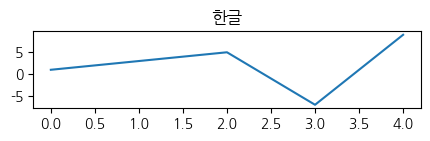

In [3]:
pd.Series([1, 3, 5, -7, 9]).plot(title="한글", figsize=(5, 1))

## 데이터 로드

In [ ]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv("data/klue/train_data.csv")
test = pd.read_csv("data/klue/test_data.csv")
train.shape, test.shape

In [ ]:
# 토픽을 불러옵니다.
topic = pd.read_csv("data/klue/topic_dict.csv")
topic

## 전처리를 위한 데이터 병합
* 학습, 예측 세트를 똑같이 전처리 해주기 위해 각각 같은 방법을 적용해 줄 수도 있지만
* 두 데이터를 병합해서 전처리를 해주고 다시 나눠주는 방법을 알아보기 위해 병합 후 나눠보겠습니다.

## concat
<img src="https://pandas.pydata.org/docs/_images/08_concat_row.svg" width="500">

In [ ]:
# 전처리를 위해 데이터 병합
# df

## 정답값 빈도수
* train 에서 제공하는 정답값의 빈도수

In [ ]:
# 정답값 빈도수를 확인합니다.
# topic_count


In [ ]:
# 정답값 빈도수를 시각화 합니다.


## 문자 전처리

In [ ]:
# 정규표현식
import re

def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub('[\s]+', ' ', text)
    # 영문자를 소문자로 만듭니다.
    text = text.lower()
    return text

In [ ]:
# map을 통해 전처리 일괄 적용
# df["title"]

### 불용어 제거

In [ ]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그', '등', '이런', '및','제', '더']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [ ]:
# df["title"]

## 학습, 예측 데이터셋 분리
* 전처리가 되었다면 concat 으로 합쳐주었던 데이터프레임을 다시 학습과 예측 데이터셋으로 분리합니다.

In [ ]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
# label_name

In [ ]:
# label_name 을 기준으로 학습, 예측 세트를 분리합니다.
# label_name 이 있다면 학습 세트, 없다면 예측 세트가 됩니다.
# df_train
# df_test

In [ ]:
# 기출문제의 정답을 만들어 줍니다.
# 잘 나뉘었는지 정닶 값의 빈도수를 확인해 봅니다.
# y_train

In [ ]:
# 테스트의 정답은 모두 결측치 입니다.
# Dacon 사이트에 예측 값을 제출해야 맞고 틀린 갯수를 알 수 있습니다.
# y_test


## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### TF-IDF(Term Frequency - Inverse Document Frequency)

정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용할 수 있다.

TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용 되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \times (\log\big(\frac{N + 1}{N_w + 1}\big) + 1)
\end{equation*}


* 출처 : [tf-idf - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/Tf-idf)

In [ ]:
# TfidfVectorizer 로 벡터화 합니다.
# fit 으로 변환할 어휘를 학습합니다.

# tfidfvect

In [ ]:
# transform
# X_train
# X_test


In [ ]:
# 단어 사전 feature_names


In [ ]:
# np.sum 으로 위에서 구한 TF-IDF 값을 단어별로 더합니다. axis=0 으로 합니다. 

# df_vocab

In [ ]:
# TF-IDF 합계 값이 높은 상위 10개 어휘
# df_vocab

In [ ]:
# 위에서 구한 빈도수를 그래프로 그립니다.


## 모델 학습



<img src="https://i.imgur.com/rKOYbeX.png">

전체 과정
* feature_names : 학습(훈련), 예측에 사용할 단어 사전 입니다.
* label_name : 정답값

* X_train : feature_names 에 해당되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 데이터셋 예) 시험의 기출문제

* X_test : feature_names 에 해당되는 컬럼만 test에서 가져옵니다.
    * 예측에 사용할 데이터셋 예) 실전 시험문제

* y_train : label_name 에 해당 되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 정답 값 예) 기출문제의 정답

* model : 학습, 예측에 사용할 머신러닝 알고리즘

* model.fit(X_train, y_train) : 학습(훈련), 기출문제와 정답을 가지고 학습(훈련)하는 과정과 유사합니다.

* model.predict(X_test) :  예측, 실제 시험을 보는 과정과 유사합니다. => 문제를 풀어서 정답을 구합니다.

* score
    * 시험을 봤다면 몇 문제를 맞고 틀렸는지 채점해 봅니다.
* metric
    * 점수를 채점하는 공식입니다. (예를 들어 학교에서 중간고사를 봤다면 전체 평균을 계산해 줍니다.)


### RandomForestClassifier

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Randomforests_ensemble.gif">

### DecisionTree와 Randomforest의 Parameter
* n_estimators
    * DecisionTree 는 트리를 하나만 만들기 때문에 없음
    * 결정트리의 개수, 많을 수록 성능이 좋아지나 오래걸리며 샘플의 수에 따라 트리를 만들 수 있는 개수가 제한적
* max_depth
    * 트리의 최대 깊이
* max_features	
    * 피처의 개수(int) 혹은 비율(float)
    * sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 사용
    * log : 전체 피처 중 log2(전체 피처 개수) 만큼 
* min_samples_split
    * 노드를 분할하기 위한 최소 샘플 데이터수
* min_samples_leaf
    * 리프노드가 되기 위해 필요한 최소 샘플 데이터수
* max_leaf_nodes
    * 리프노드의 최대 개수
* n_jobs
    * 사용할 CPU 코어의 수, -1로 설정 시 사용할 수 있는 모든 CPU코어를 사용
    

In [ ]:
# RandomForestClassifier 를 불러옵니다.


## 교차 검증

<img src="https://i.imgur.com/x9M8zpI.png" width="600">

In [ ]:
# cross_val_predict 로 교차 검증을 합니다.


### 교차 검증 정확도

In [ ]:
# 교차 검증 결과 


In [ ]:
# 교차 검증 결과 점수를 구해봅니다.
# 모의고사를 보고 채점해 보는 과정과 유사합니다.
# valid_accuracy

In [ ]:
# df_accuracy 로 정답여부 컬럼을 만듦
# df_accuracy

In [ ]:
# groupby 로 분류별 정확도를 구합니다.
# df_group_accuracy

## 학습

In [ ]:
# fit 으로 학습시킵니다.


In [ ]:
# 피처 중요도 구하기


## 예측

In [ ]:
# 실전 시험과 유사합니다. 정답 없이 문제만 넣고 풀어서 예측합니다.
# predict로 예측합니다. 
# y_predict

## 정답값 로드

In [ ]:
# sample_submission 파일을 불러옵니다.
# Dacon 에 제출할 답안지 양식입니다.
submit = pd.read_csv("data/klue/sample_submission.csv")
submit.head()

In [ ]:
# 정답값 측정을 위해 y_test 변수에 할당
# submit["topic_idx"]

In [ ]:
file_name = f"data/klue/submit_{valid_accuracy}.csv"
file_name

In [ ]:
# 파일로 저장합니다.


In [ ]:
# 잘 저장이 되었는지 확인합니다.


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경